In [105]:
# imports
%matplotlib inline
from bs4 import BeautifulSoup
import urllib2
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import psycopg2, psycopg2.extras
import string
import re
from collections import Counter
from dateutil import relativedelta
import datetime

from textwrap import wrap
from ds_api.cache_utils import add_to_cache, load_cache


In [91]:
month_map = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

In [258]:
def plotCoeffs(factor_name, ucoeffs, drop_cats, width, height, legend1_v = 1.02, legend2_v = 1.04, show_legend = 1):
    idx = [factor_name in t for t in ucoeffs.term]
    bardata = pd.DataFrame()

    #actual estimates
    bardata['predConvRate'] = ucoeffs['predConvRate'][idx]

    #multiplicative estimates
    bardata['multip_estimate'] = 100*np.exp(ucoeffs['estimate'][idx])
    bardata['multip_std.error'] = 100*(np.exp(ucoeffs['estimate'].iloc[idx] + ucoeffs['std.error'].iloc[idx]) - np.exp(ucoeffs['estimate'].iloc[idx]))

    #labels
    bardata['term'] = ucoeffs['term'][idx].str.replace(factor_name,'')
    bardata['term'] = ['\n'.join(wrap(bt,23)) for bt in bardata.term]

    idxDrop = ([bt in drop_cats for bt in bardata.term] | (bardata['multip_std.error'] > 100))
    #idxDrop = ((bardata.term in drop_cats) | (bardata['multip_std.error'] > 100))
    bardata = bardata[~idxDrop]


    plt.rcParams['figure.figsize'] = [width, height]

    sortidx = np.argsort(bardata['predConvRate'])[::-1]
    f, ax = plt.subplots()

    #width = 0.5
    width = 0.4

    colors = np.array(['#ffb4ae']*len(bardata.term))
    colors[np.where(bardata.term=='EVG')[0]] = 'r'

    #Multiplicative (add position = 0 to barh function when including non multiplicative)
    bardata['multip_estimate'].iloc[sortidx].plot(ax=ax,kind='barh', xerr = [[[0]*len(bardata['multip_std.error']),bardata['multip_std.error'].iloc[sortidx]]], 
                                            color = colors[sortidx], fontsize = '20', width = width, position = 0)
    
    plt.tight_layout()
    ax.set_xlabel('Conversion rate (percent of baseline category)', fontsize='20')
    if show_legend == 1:
        ax.legend({'Conversion Rate (percent of baseline category - Model Coefficients)'},bbox_to_anchor=(0., legend1_v, 0.7, .102), loc=3,
               ncol=1, mode="expand", borderaxespad=0., fontsize = '17')
    ax.set_xticks(range(0,125, 25))

    #Non-multiplicative
    ax2 = ax.twiny()
    
    colors = np.array(['#4599ae']*len(bardata.term))
    colors[np.where(bardata.term=='EVG')[0]] = 'b'
    
    bardata['predConvRate'].iloc[sortidx].plot(ax=ax2,kind='barh', 
                                           color = colors[sortidx], fontsize = '20', position = 1, width = width)
    ax2.set_xlabel('Conversion Rate Estimate', fontsize='20')

    if show_legend == 1:
        ax2.legend({'Conversion Rate Estimate (Bottom Axis)'}, bbox_to_anchor=(0, legend2_v, 0.7, .102), loc=3,
               ncol=1, mode="expand", borderaxespad=0., fontsize = '17')
    ax.set_yticklabels(bardata['term'].iloc[sortidx])
    plt.ylim([-1.1, len(bardata)+0.1]);

    plt.grid('off')
    plt.show();
    

# Introduction

In this post we use the ad conversion model to expand on historical analysis of Evergreen ads. 

*  In a [previous post](https://app.datascience.com/insights/brand-conversion-initial-model-results-i2b9a0), we have described our methodology and model for producing brand rankings.


*  In this post we present results of the model from historical analysis of Evergreen ads.  Analysis covers the historical period spanning from Nov 1 2015 to Aug 24 2016.
  

# Key Findings

Our overall findings show that Evergreen ads perform better than most franchises and themes.

* On average Evergreen ads outperform non-Evergreen ads.


* Evergreen ads tend to rank just above the middle of the range against franchises and themes.


* Even though Evergreen ads perform higher than average, many high-performing franchises such as Overwatch, Fallout, Harry Potter and Yu-Gi-Oh! outperform Evergreen ads.

# Results

The figures below show regression results for Evergreen ad analysis. We first analyze how Evergreen ad conversion compares with franchises and themes for the entire historical period. We then present results showing Evergreen ad performance for each month.

In [120]:
#Transfer Coeff CSVs to cache
add_to_cache('../data/BoxesCoeffcs.csv','lc_brand_univ_coefs')
add_to_cache('../data/UCoeffcs.csv', 'lc_brand_univ_coefs')
add_to_cache('../data/SUCoeffcs.csv', 'lc_brand_univ_coefs')
add_to_cache('../data/ThemesCoeffcs.csv', 'lc_brand_univ_coefs')
add_to_cache('../data/CICoeffcs.csv', 'lc_brand_univ_coefs')
add_to_cache('../data/EVGCoeffcs.csv', 'lc_brand_univ_coefs')
add_to_cache('../data/SUEVGCoeffcs.csv', 'lc_brand_univ_coefs')
add_to_cache('../data/THEVGCoeffcs.csv', 'lc_brand_univ_coefs')

saving to s3
saving to s3
saving to s3
saving to s3
saving to s3
saving to s3
saving to s3
saving to s3


In [121]:
directory = '../data/'
for filename in os.listdir(directory):
    if filename.endswith(".csv") and filename.startswith('SUEVGMCoeffcs_'): 
        add_to_cache(directory + filename, 'lc_brand_univ_coefs')


saving to s3
saving to s3
saving to s3
saving to s3
saving to s3


In [122]:
directory = '../data/'
for filename in os.listdir(directory):
    if filename.endswith(".csv") and filename.startswith('EVGMCoeffcs_'): 
        add_to_cache(directory + filename, 'lc_brand_univ_coefs')

saving to s3
saving to s3
saving to s3
saving to s3
saving to s3


In [123]:
directory = '../data/'
for filename in os.listdir(directory):
    if filename.endswith(".csv") and filename.startswith('THEVGMCoeffcs_'): 
        add_to_cache(directory + filename, 'lc_brand_univ_coefs')

saving to s3
saving to s3
saving to s3
saving to s3
saving to s3


# Evergreen Performance Over The Entire Historical Period

The two figures that follow show performance of Evergreen ads (EVG category) compared to franchises (first figure) and themes (second figure).  In both analyses Evergreen ads perform better than average, and are in the top half of in the category sets for franchises and for themes.

Although Evergreen ads perform better than average, there are a number of franchises and themes that significantly perform better than Evergreen ads during the historical period. 

In [260]:
ucoeffs = pd.read_csv(load_cache('../data/SUEVGCoeffcs.csv', 'lc_brand_univ_coefs'), sep = '\t')

file exists in cache


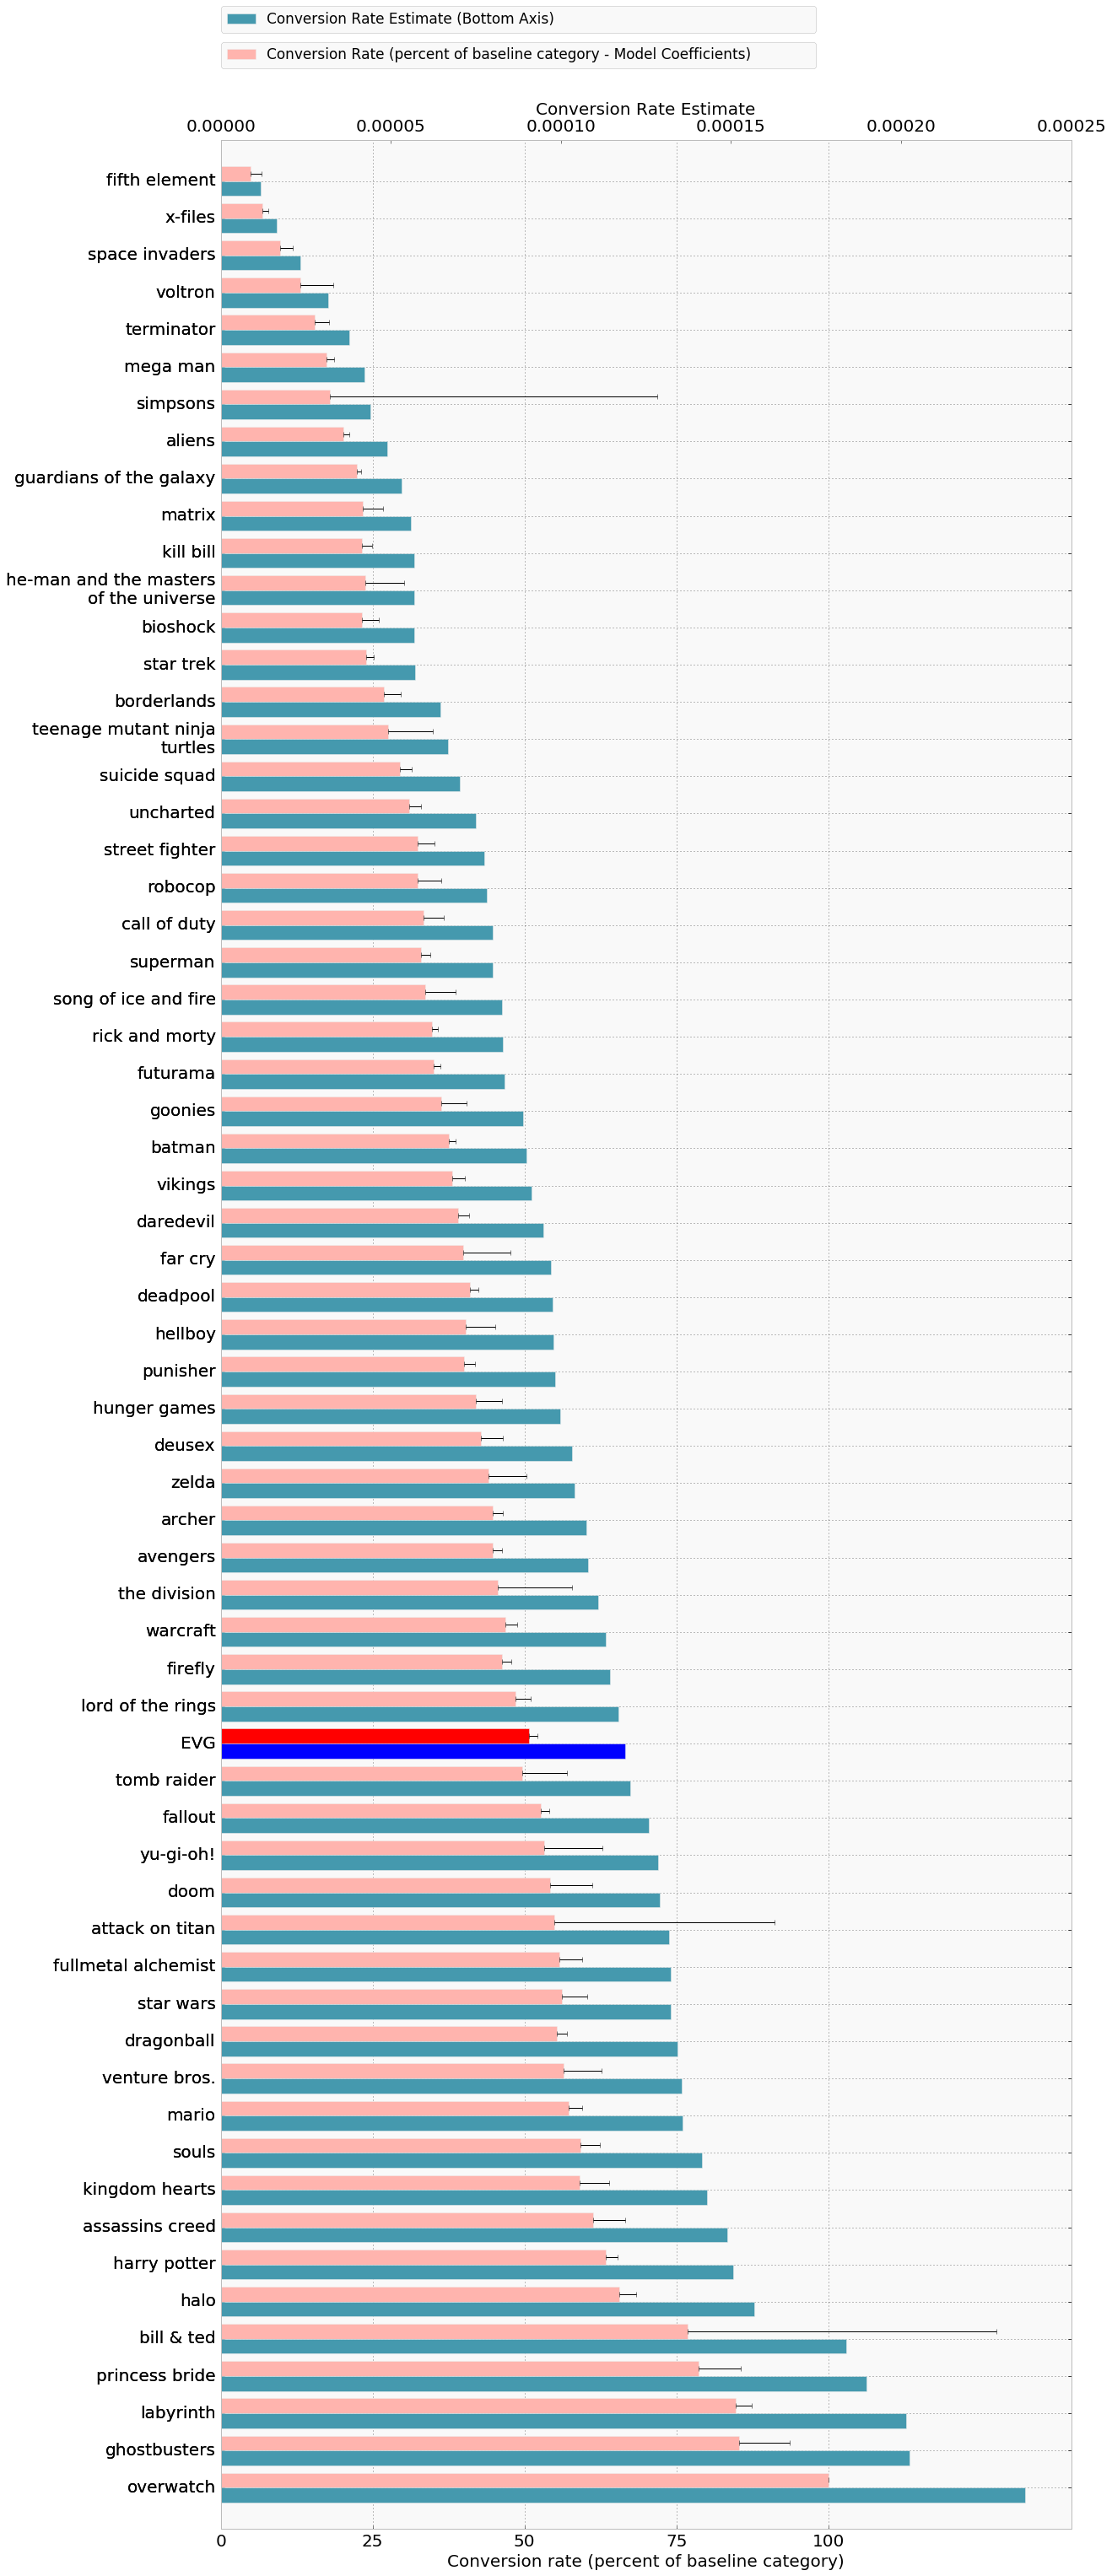

In [261]:
drop_cats = ['0', 'funkopop', 'bravest warriors', 'grand theft auto', 'tron', 'destiny', 'yu gi oh!',
                 'the divison', 'doctor who', 'adventure time']
plotCoeffs('subuniv_match_evg', ucoeffs, drop_cats, 15, 40, 1.03, 1.045, 1)

In [262]:
ucoeffs = pd.read_csv(load_cache('../data/THEVGCoeffcs.csv', 'lc_brand_univ_coefs'), sep = '\t')

file exists in cache


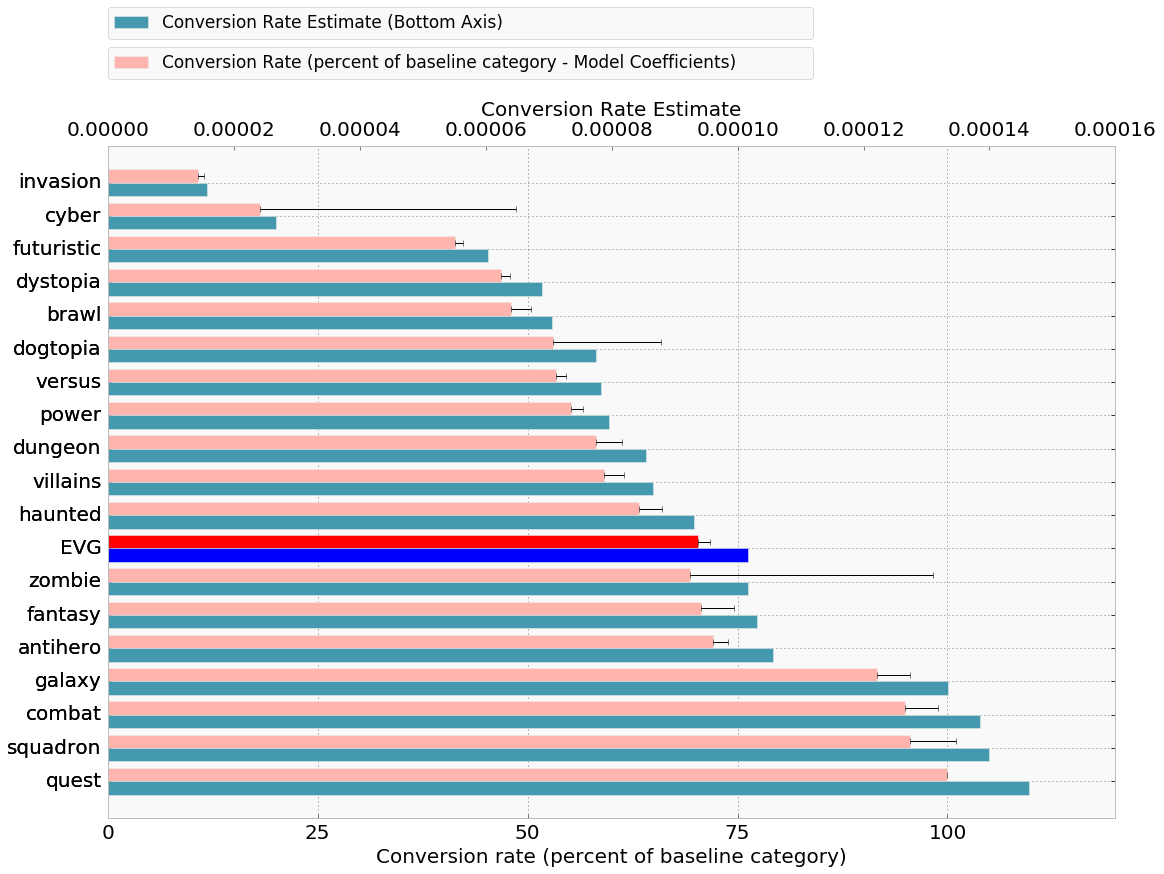

In [263]:
drop_cats = ['0']
plotCoeffs('themes_evg', ucoeffs,drop_cats, 15, 10, 1.10, 1.16, 1)

# Evergreen Ad Performance for Each Month

The following sets of figures shows analysis results of Evergeen ads individually for each month.  Only the months from April through August are included in our analysis as Evergreen ads prior to this period also cointained other tags that could be franchise or theme related. Note that analysis on the 'theme' and 'franchise' levels show large error bars due to limited data when looking at only data for a single month.  As a result, ranking order may change for similar themes and franchises between months.

The first set of figures shows how Evergreen ads perform on average in each month compared to all Non Evergreen ads for that month.  With the exception of April, Evergreen ads perform better than Non Evergreen ads.  In addition, the difference between Evergreen and Non Evergreen Ads remains generally constant over the months of May to August.

In [272]:
ucoeffsList = []
month_list = []

for filename in os.listdir(directory):
    if filename.endswith(".csv") and filename.startswith('EVGMCoeffcs_'):
        ucoeffsList.append(pd.read_csv(load_cache(directory + filename, 'lc_brand_univ_coefs'), sep = '\t'))
        month_list.append(int(filename.split('_')[1].split('.')[0]))

file exists in cache
file exists in cache
file exists in cache
file exists in cache
file exists in cache


In [273]:
show_legend = 1
evg_true = []
evg_false = []
for i, ucoeffs in enumerate(ucoeffsList):
    drop_cats = []
    #drop_cats = ['0', 'funkopop', 'bravest warriors', 'grand theft auto', 'tron', 'destiny', 'yu gi oh!',
    #             'the divison', 'doctor who', 'adventure time']
    
    print('Month:  ' + month_map[month_list[i]-1])
    plotCoeffs('EVG', ucoeffs,drop_cats, 15, 2.5, 1.50, 1.80, show_legend)
    
    evg_true.append(ucoeffs[['EVGTRUE' in uc for uc in ucoeffs.term]].predConvRate.iloc[0])
    evg_false.append(ucoeffs[['EVGFALSE' in uc for uc in ucoeffs.term]].predConvRate.iloc[0])
    
    show_legend = 0
    





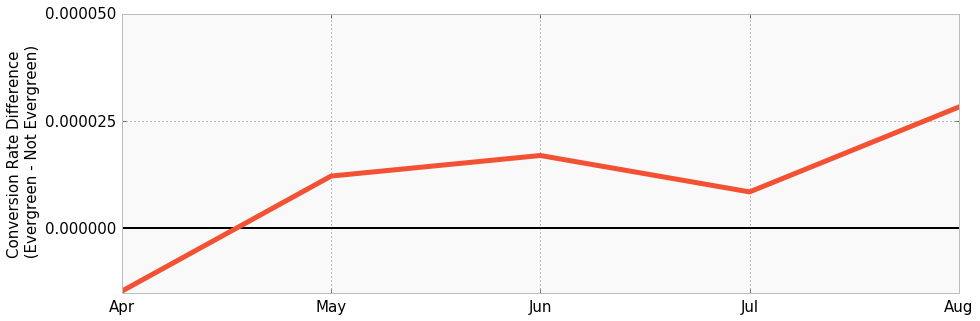

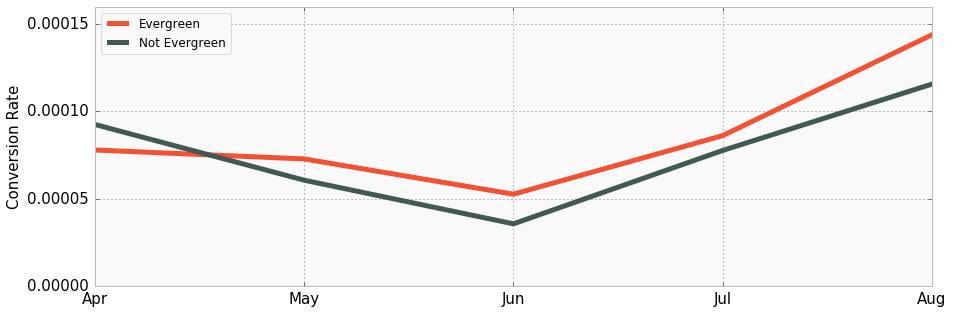

In [276]:
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)
plt.rcParams['figure.figsize'] = [15,5]
plt.axhline(0, color = 'k', linewidth = 2)
plt.plot(np.array(month_list),np.array(evg_true)-np.array(evg_false), linewidth = 5)
plt.yticks([0, 0.000025, 0.00005])
plt.xticks(month_list, np.array(month_map)[np.array(month_list)-1])
plt.ylabel('Conversion Rate Difference\n (Evergreen - Not Evergreen)')
plt.show();

plt.plot(np.array(month_list),evg_true, linewidth = 5)
plt.plot(np.array(month_list),evg_false, linewidth = 5)
plt.xticks(month_list, np.array(month_map)[np.array(month_list)-1])
plt.yticks([0, 0.00005, 0.00010, 0.00015])
plt.xticks
plt.ylabel('Conversion Rate')
plt.legend(['Evergreen','Not Evergreen'], loc = 'upper left')
plt.show();

The second set of figures shows how Evergreen ads perform compared to theme ads for each month. With the exception of April, Evergreen ads rank at or above the middle of the range.

In [267]:
ucoeffsList = []
month_list = []

for filename in os.listdir(directory):
    if filename.endswith(".csv") and filename.startswith('THEVGMCoeffcs_'):
        
        ucoeffsList.append(pd.read_csv(load_cache(directory + filename, 'lc_brand_univ_coefs'), sep = '\t'))
        month_list.append(int(filename.split('_')[1].split('.')[0]))


file exists in cache
file exists in cache
file exists in cache
file exists in cache
file exists in cache


Month:  Apr


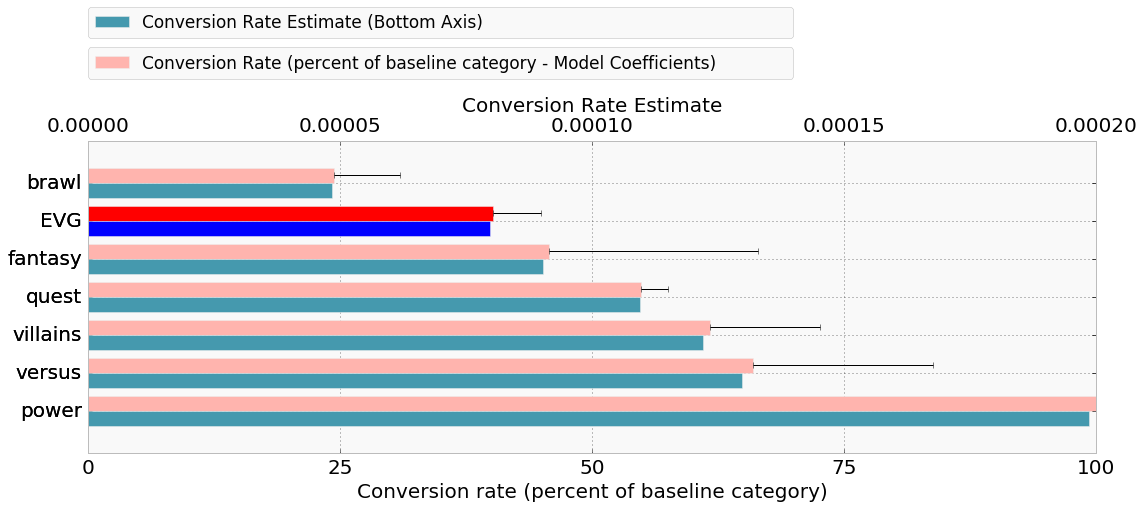

Month:  May


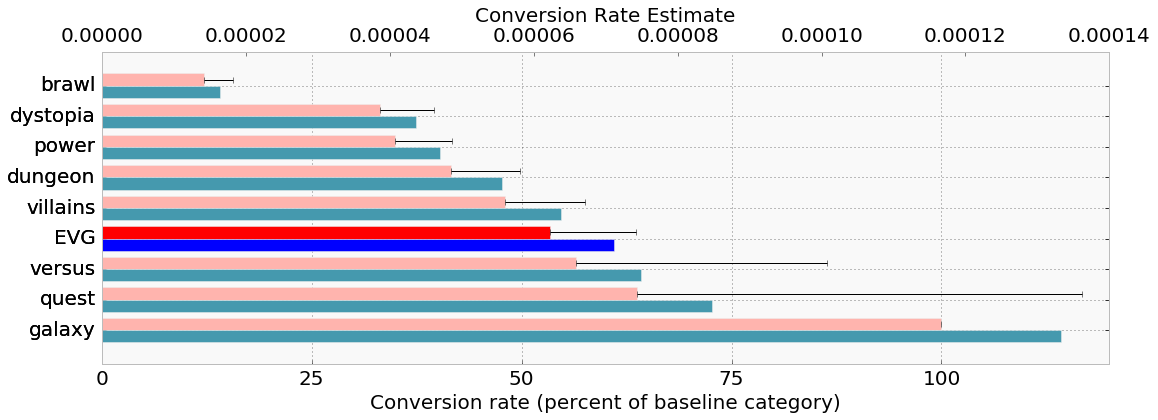

Month:  Jun


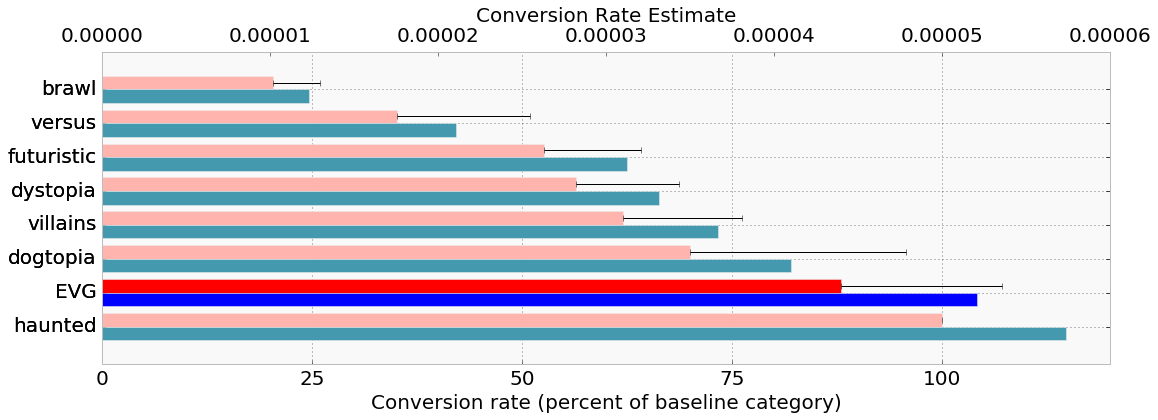

Month:  Jul


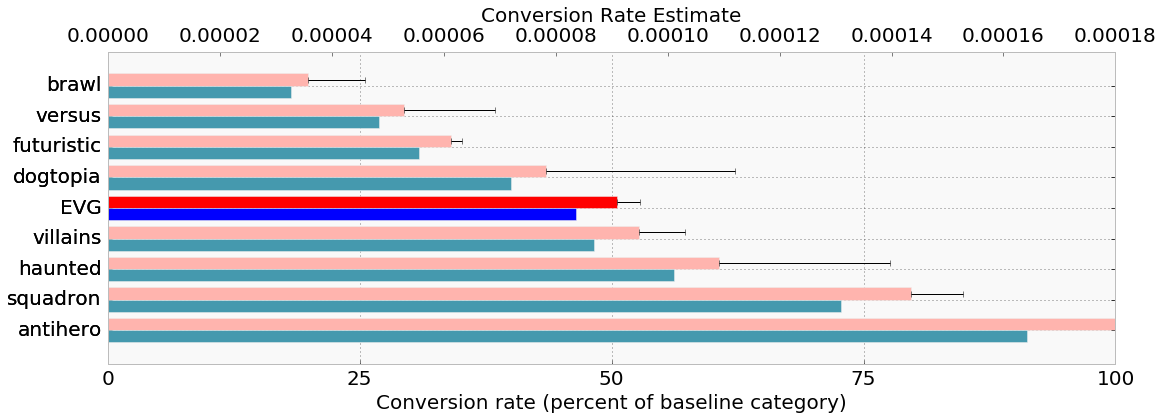

Month:  Aug


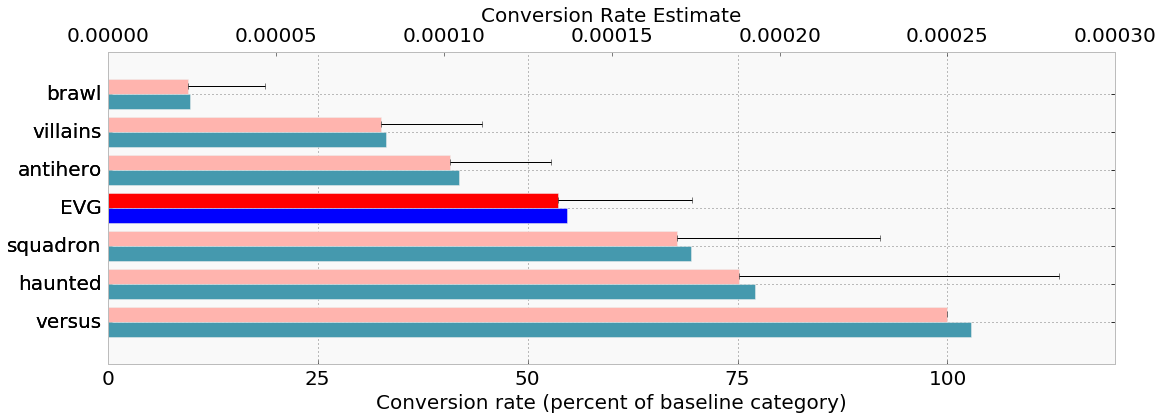

In [268]:
show_legend = 1
for i, ucoeffs in enumerate(ucoeffsList):
    drop_cats = ['0']
    #drop_cats = ['0', 'funkopop', 'bravest warriors', 'grand theft auto', 'tron', 'destiny', 'yu gi oh!',
    #             'the divison', 'doctor who', 'adventure time']
    print('Month:  ' + month_map[month_list[i]-1])
    plotCoeffs('themes_evg', ucoeffs,drop_cats, 15, 5, 1.20, 1.33, show_legend)
    show_legend = 0

The third set of figures compares Evergreen ads to franchises for each month.  Like in previous figures Evergreen ads tend to rank toward the middle and upper end of the range compared to franchise ads.

In [269]:
ucoeffsList = []
month_list = []
for filename in os.listdir(directory):
    if filename.endswith(".csv") and filename.startswith('SUEVGMCoeffcs_'):
        ucoeffsList.append(pd.read_csv(load_cache(directory + filename, 'lc_brand_univ_coefs'), sep = '\t'))
        month_list.append(int(filename.split('_')[1].split('.')[0]))

file exists in cache
file exists in cache
file exists in cache
file exists in cache
file exists in cache


Month: Apr


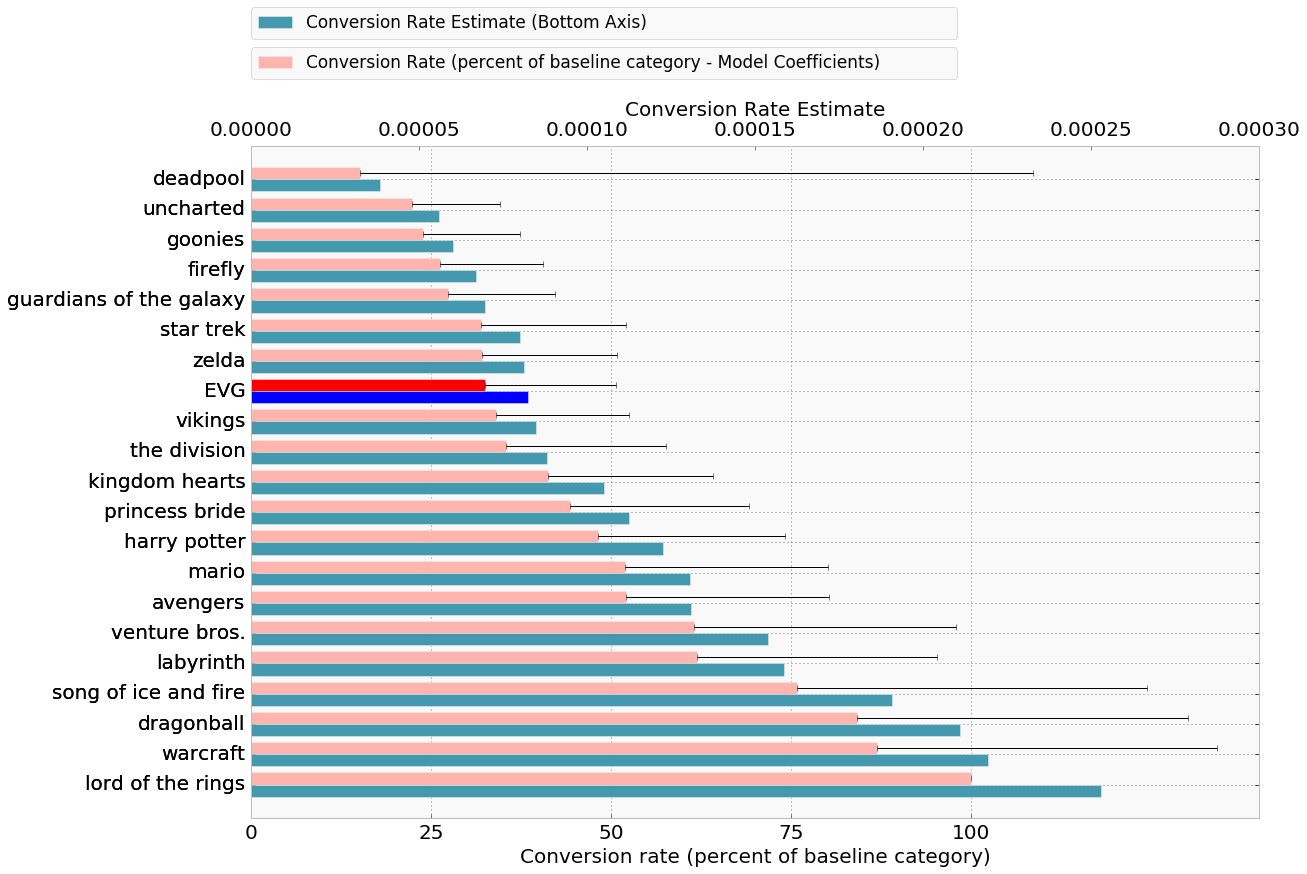

Month: May


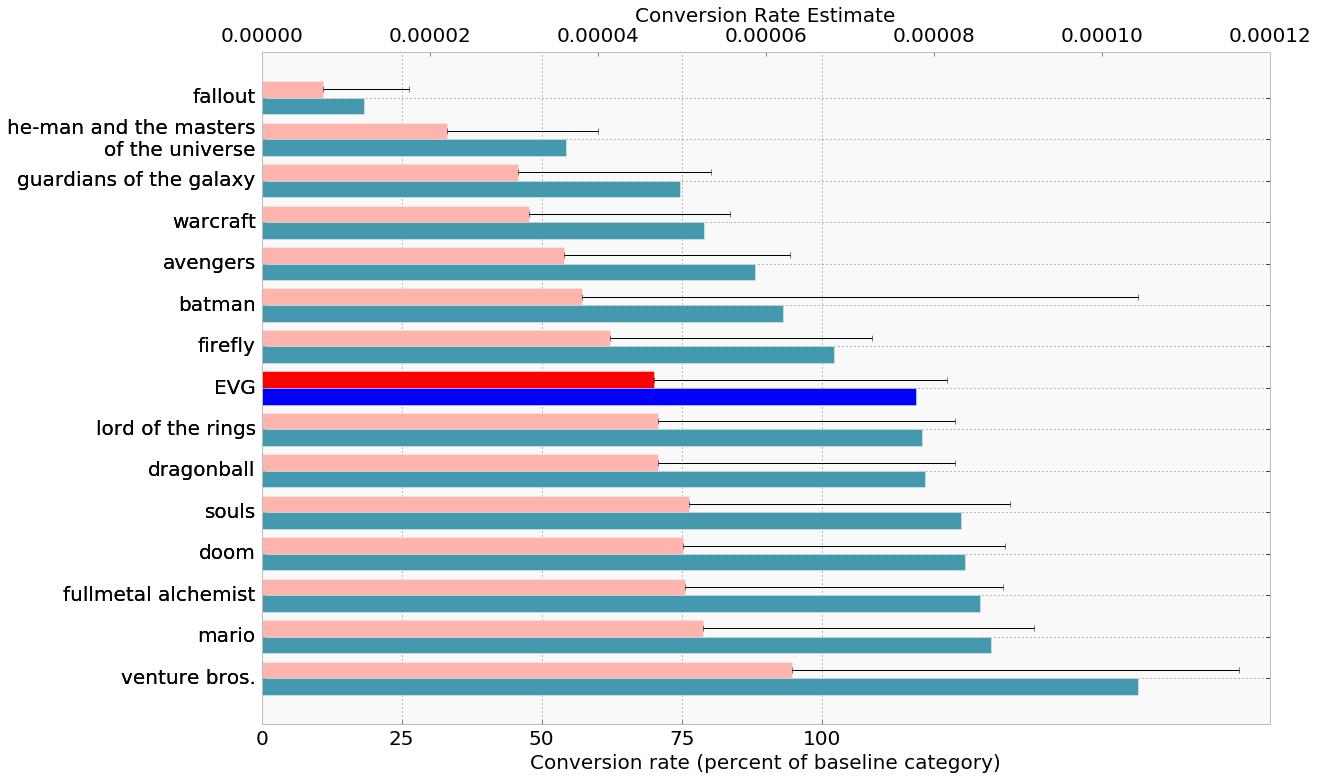

Month: Jun


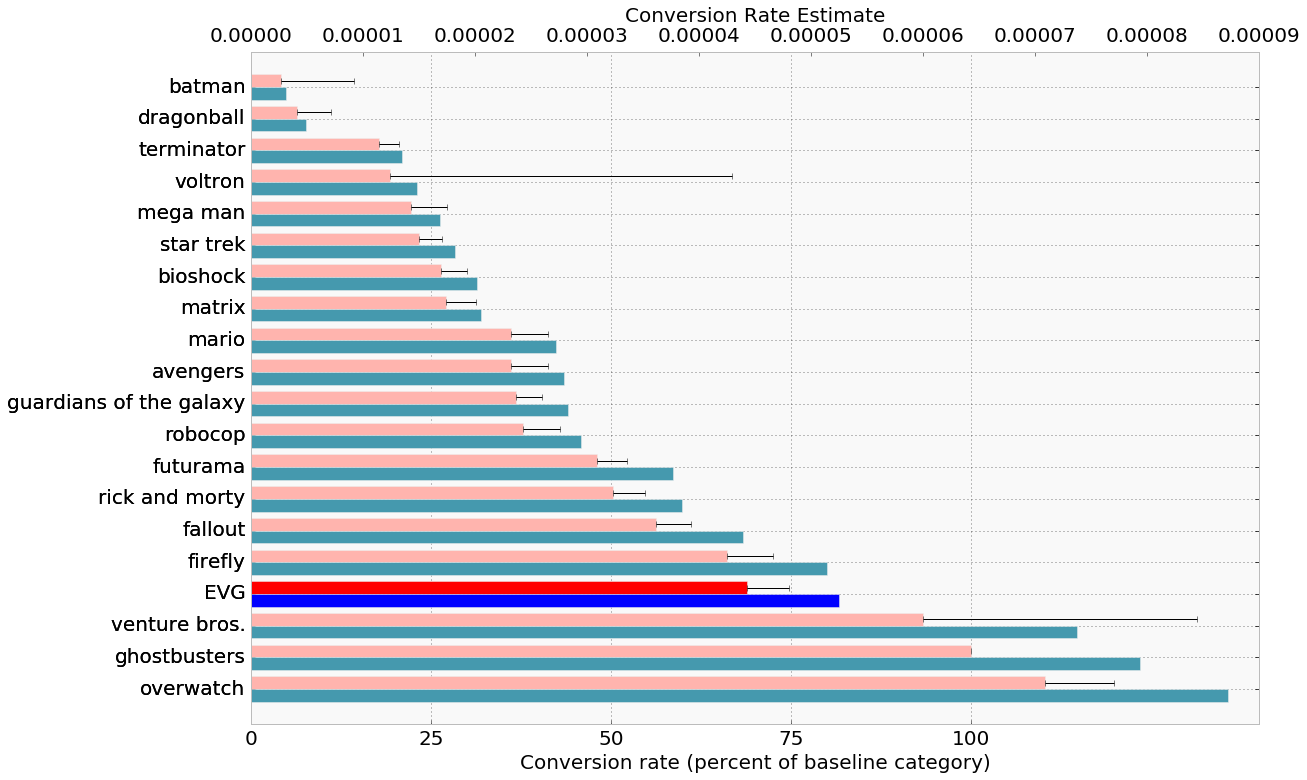

Month: Jul


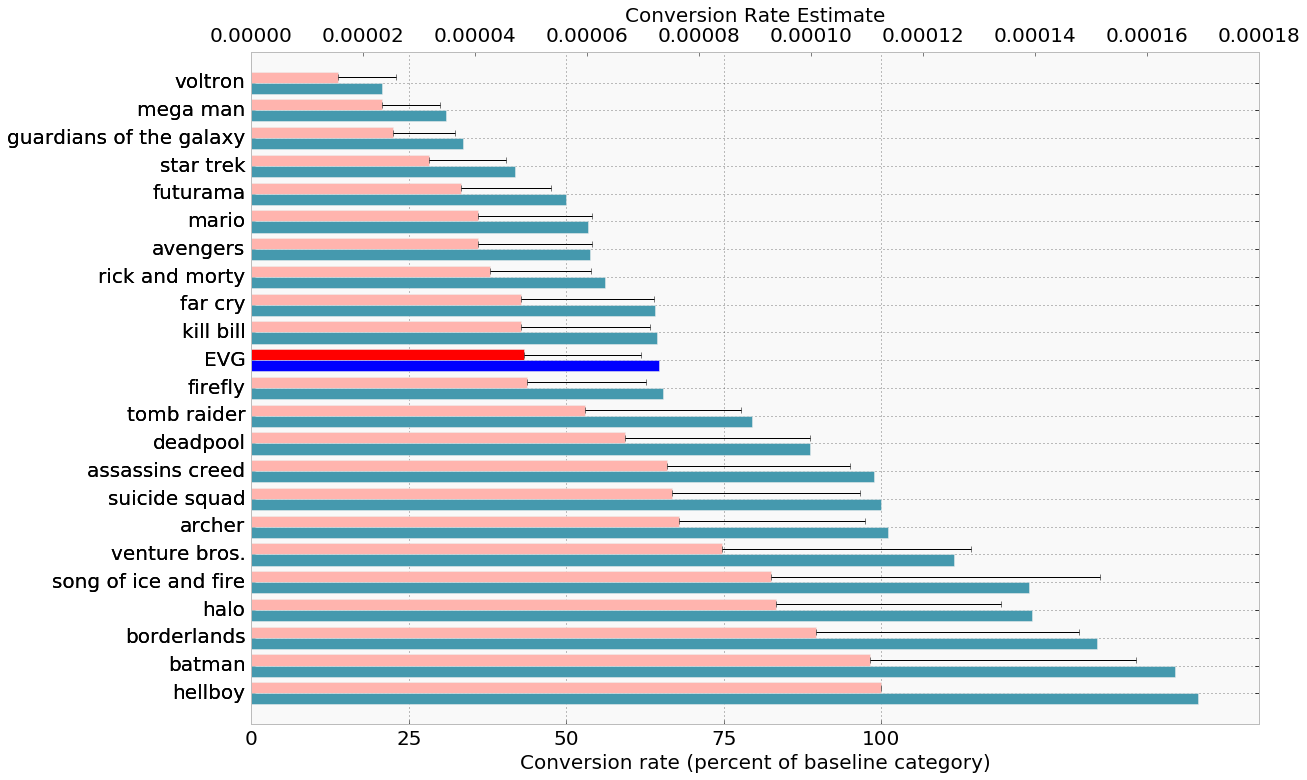

Month: Aug


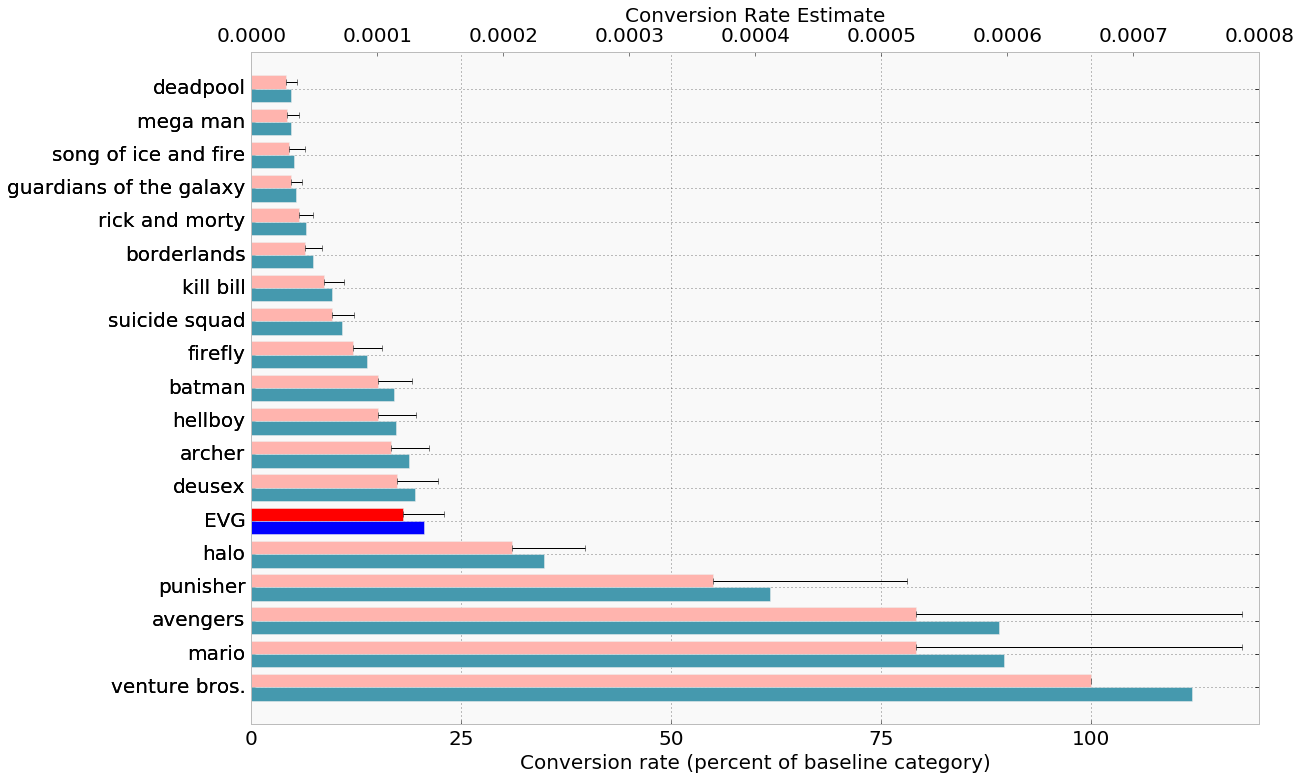

In [270]:
show_legend = 1
for i, ucoeffs in enumerate(ucoeffsList):
    drop_cats = ['0', 'funkopop', 'bravest warriors', 'grand theft auto', 'tron', 'destiny', 'yu gi oh!',
                 'the divison', 'doctor who', 'adventure time']
    print('Month: ' + month_map[month_list[i]-1])
    plotCoeffs('subuniv_match_evg', ucoeffs,drop_cats, 15, 10, 1.10, 1.16, show_legend)
    show_legend = 0

# Impact and Further Opportunity

*  On average, Evergreen ads outperform Non-Evergreen ads for the months between May through August.  Non-Evergreen ads only perform better in April.


*  During the full historical period, Evergreen ads rank just above the middle of the range for both theme-level and franchise-level analysis.  


*  This pattern holds in analysis of monthly data, though limited data produces generally more variable estimates of ad conversion.


*  These findings show that although Evergreen ads outperform Non-Evergreen ads on average, many franchises and themes still do better than Evergreen ads.  In addition, this analysis does not examine how Evergreen ads perform to acquiring new subscribers.  That is, good performance of Evergreen ads may be driven by people who are already subscribers or who are very aware of Loot Crate's offerings.  Franchise-based ads may perform much more strongly to introduce Loot Crate to new customers who are not aware of the product. 
